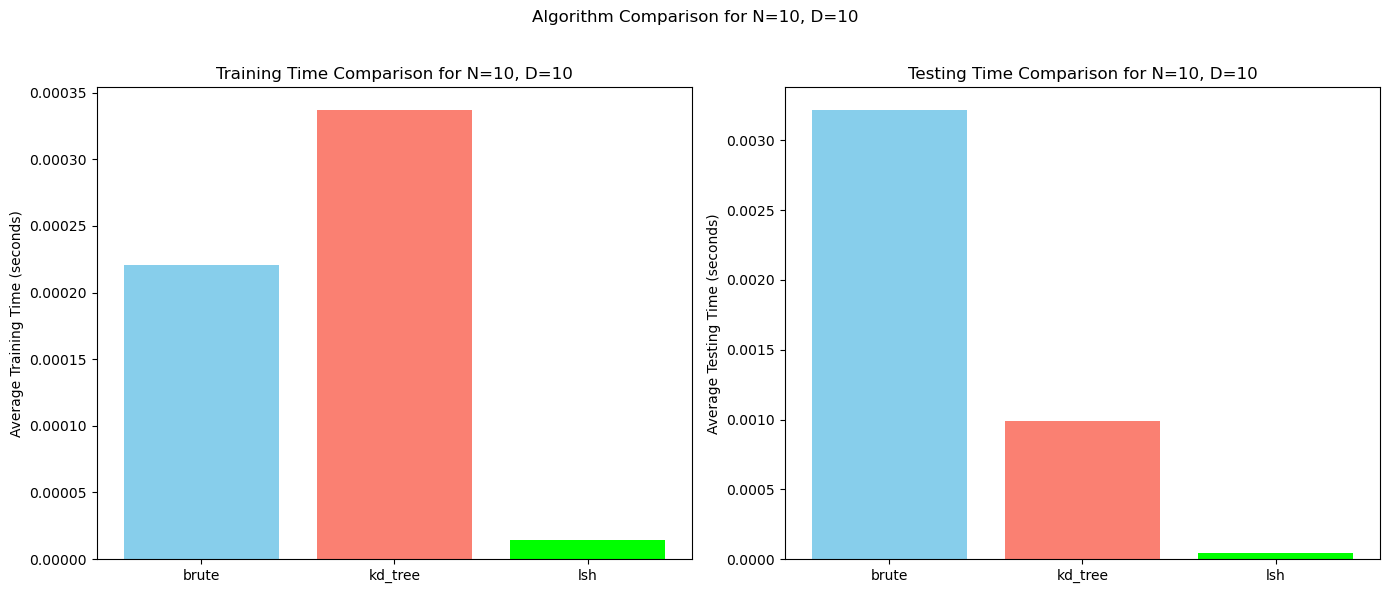

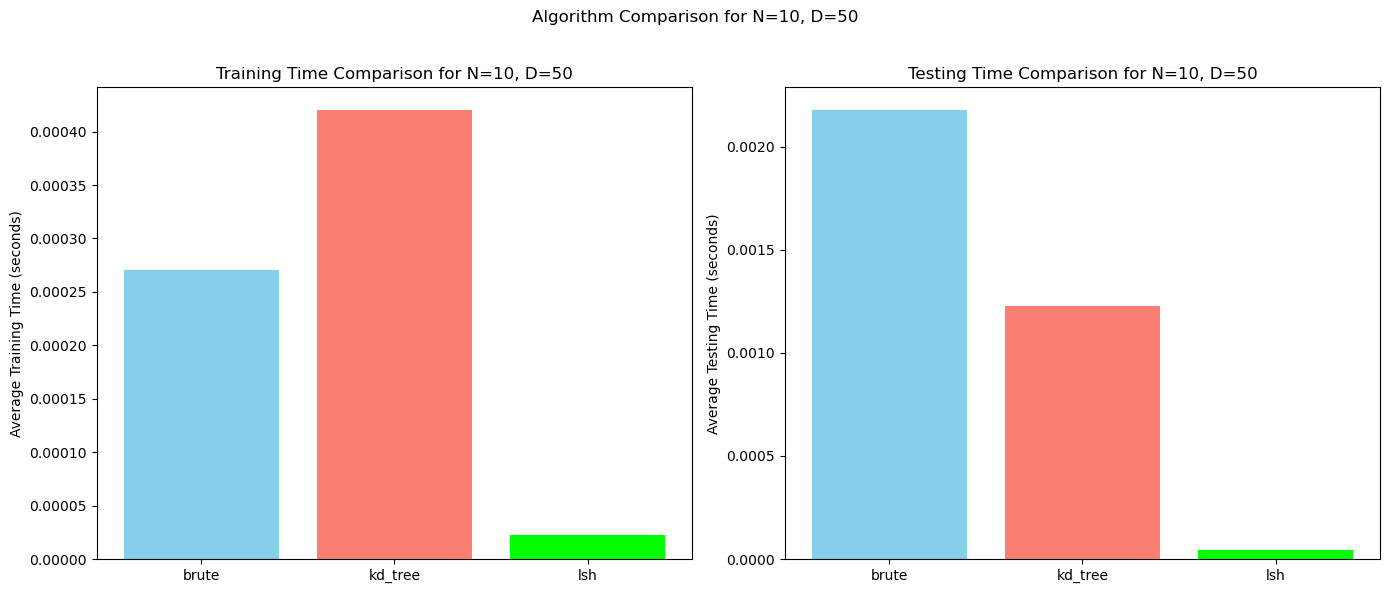

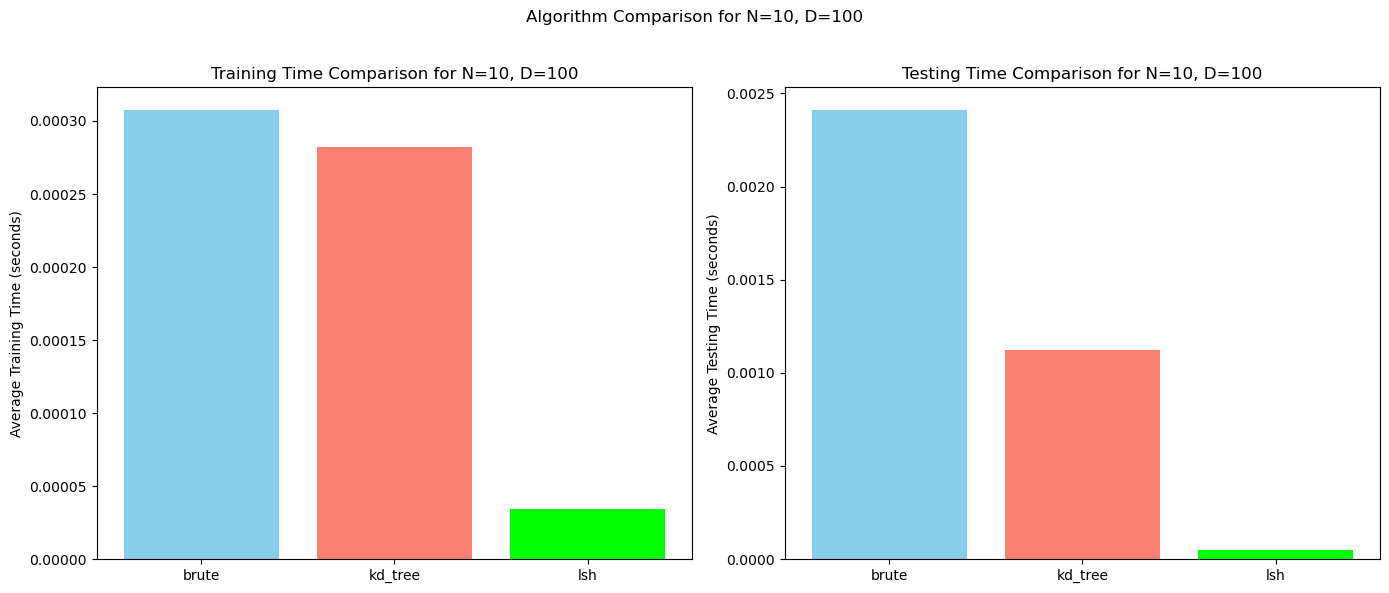

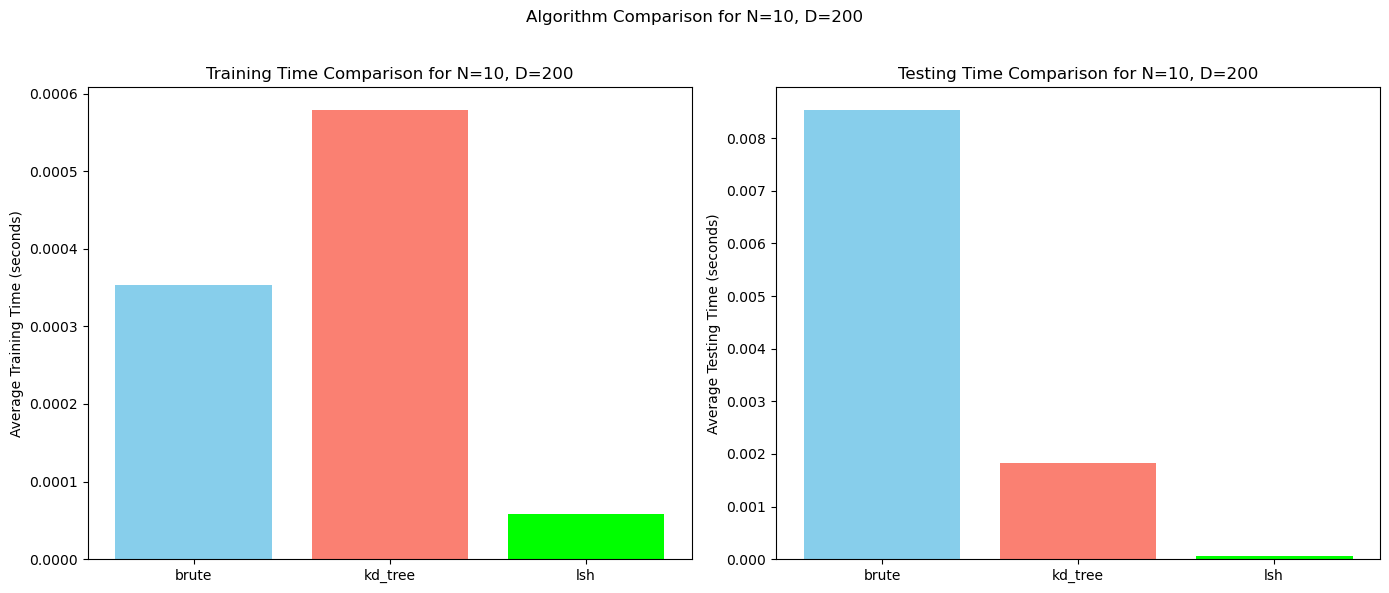

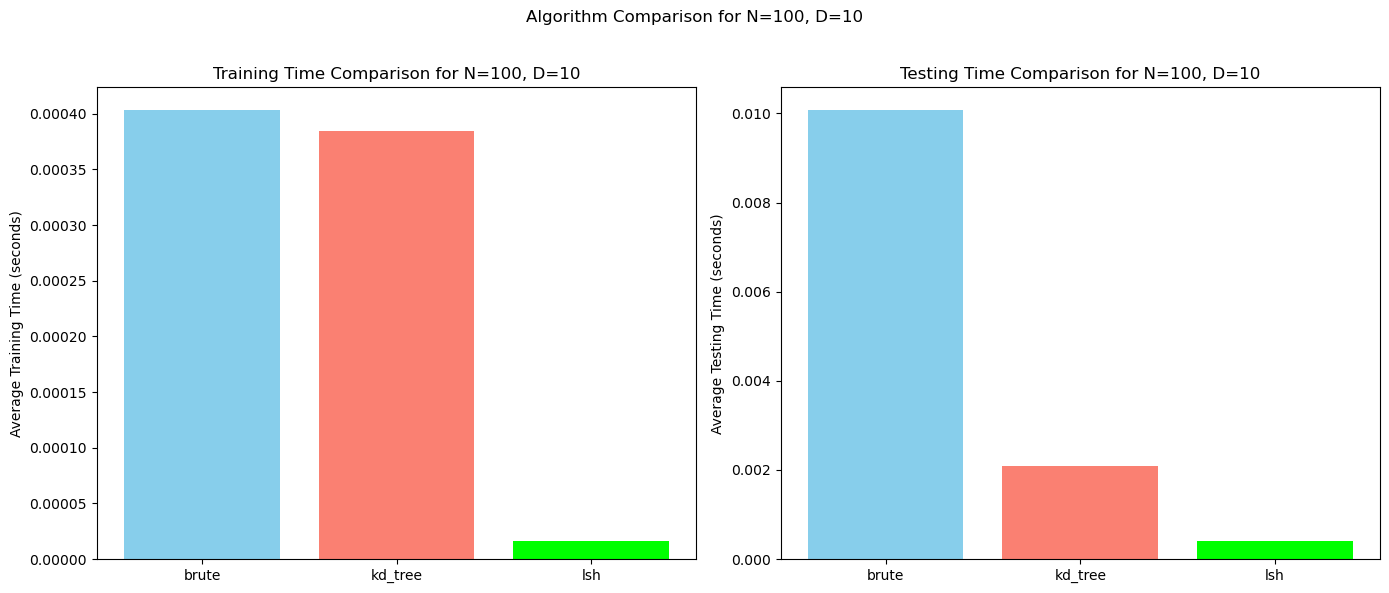

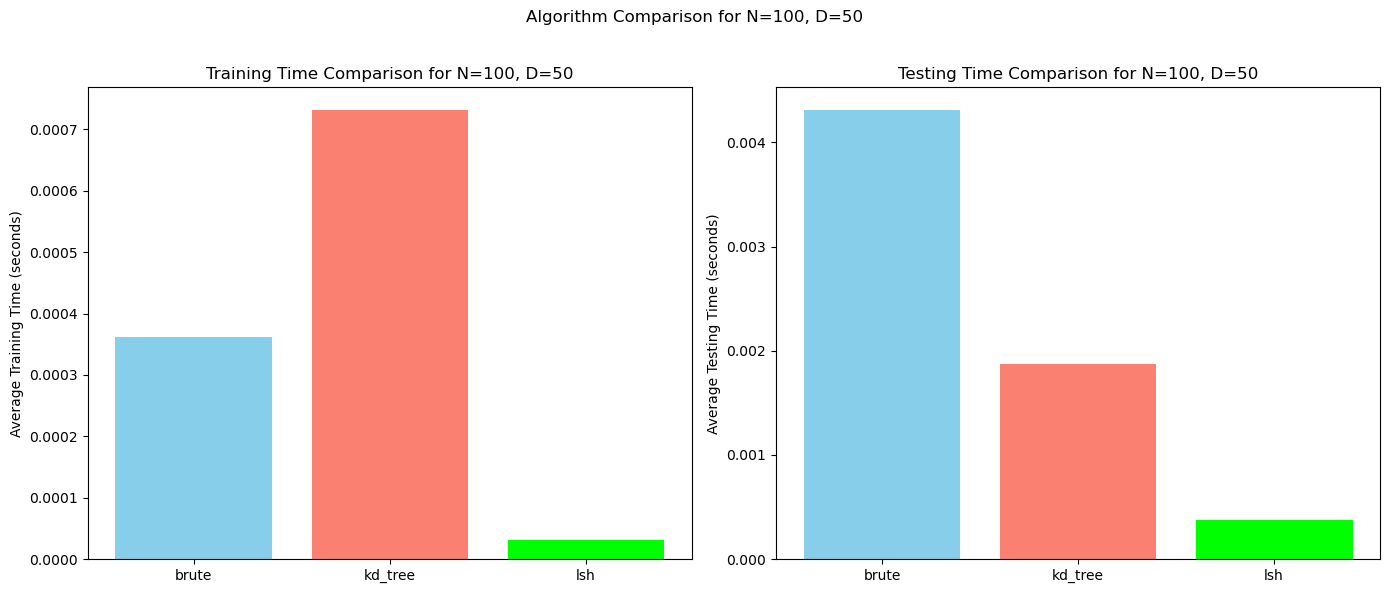

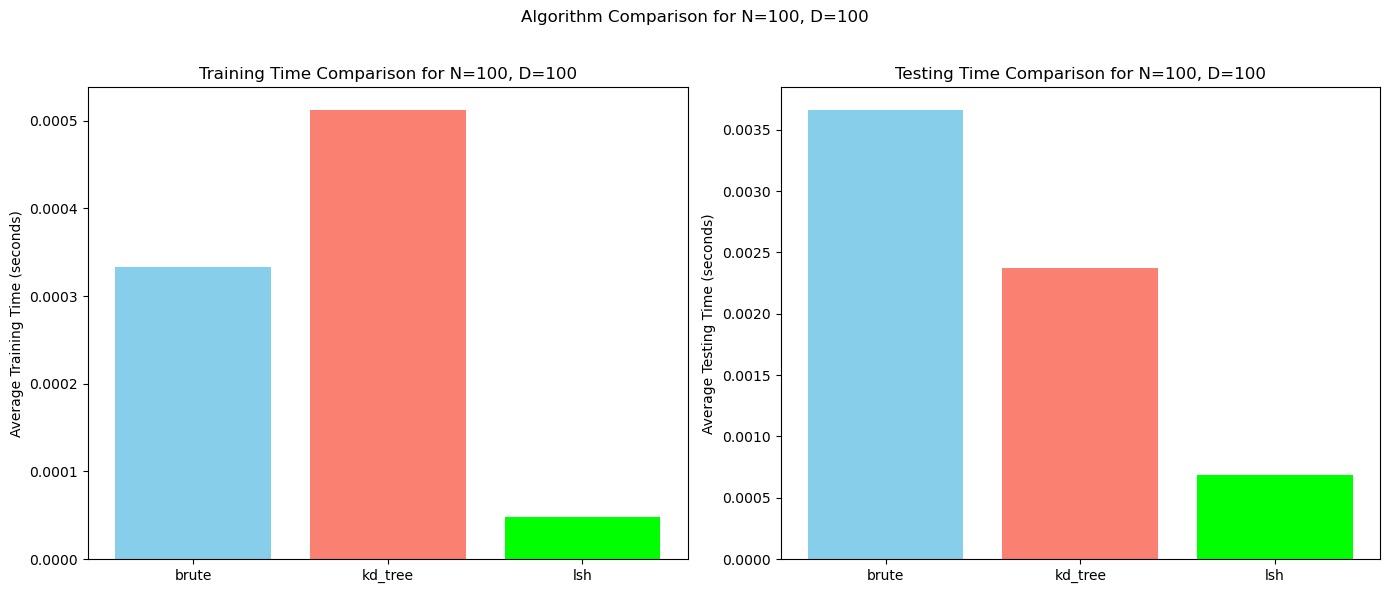

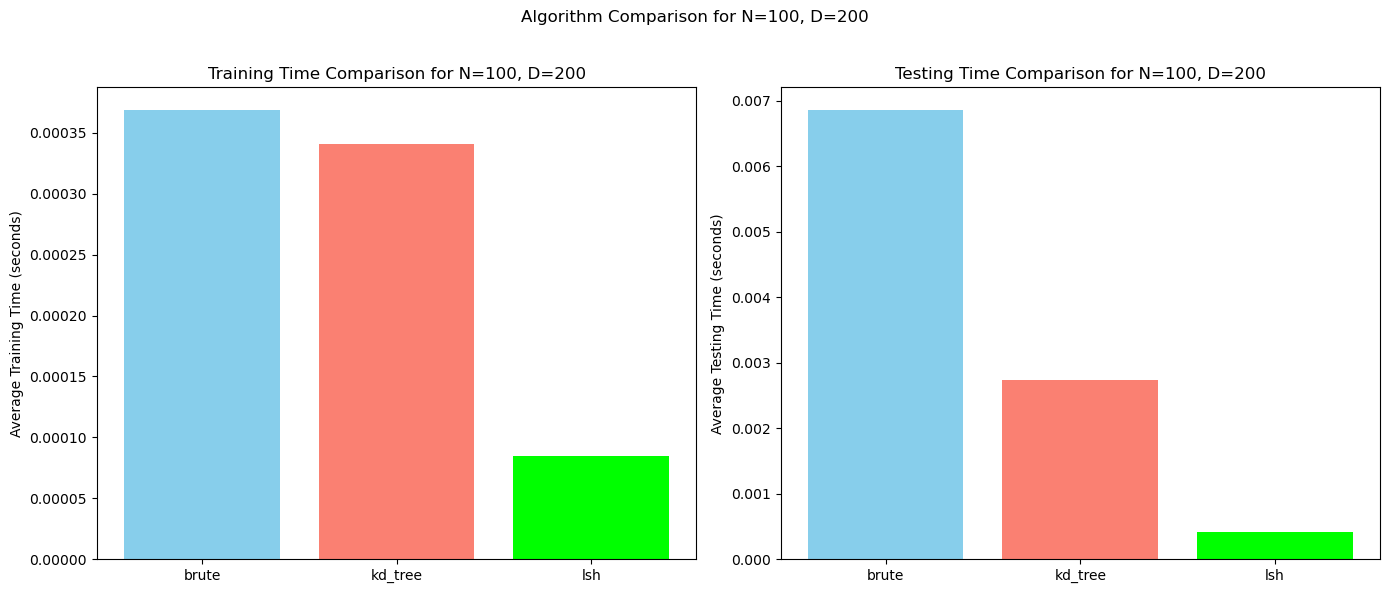

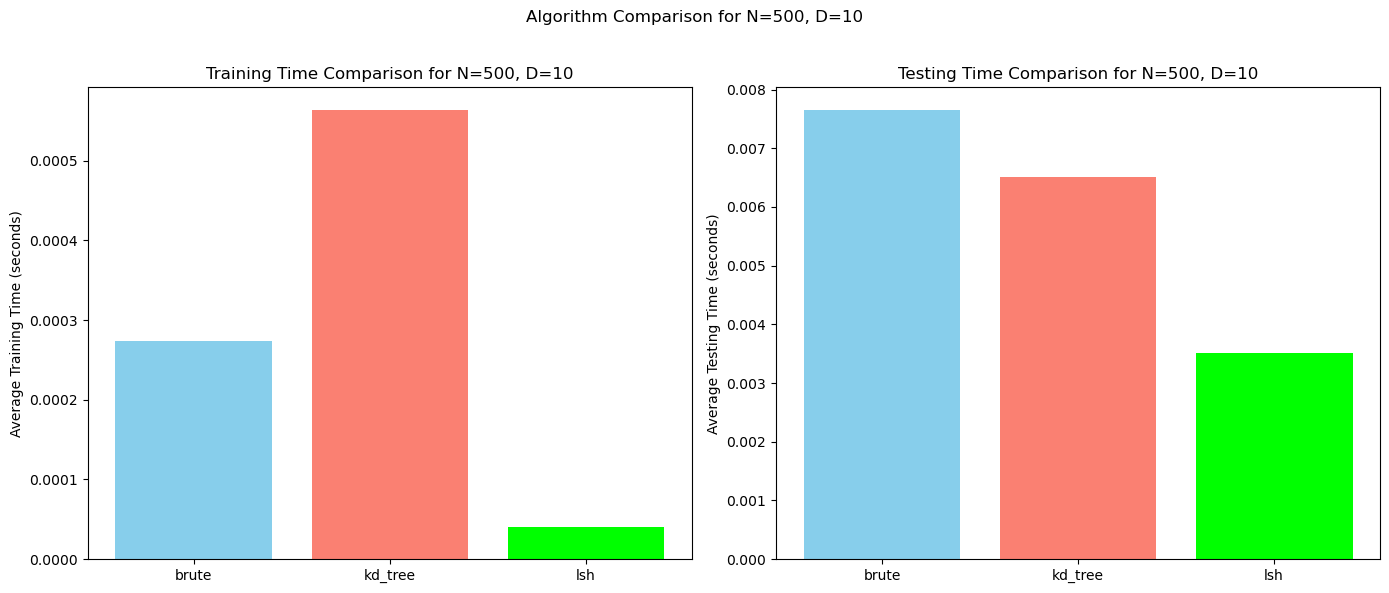

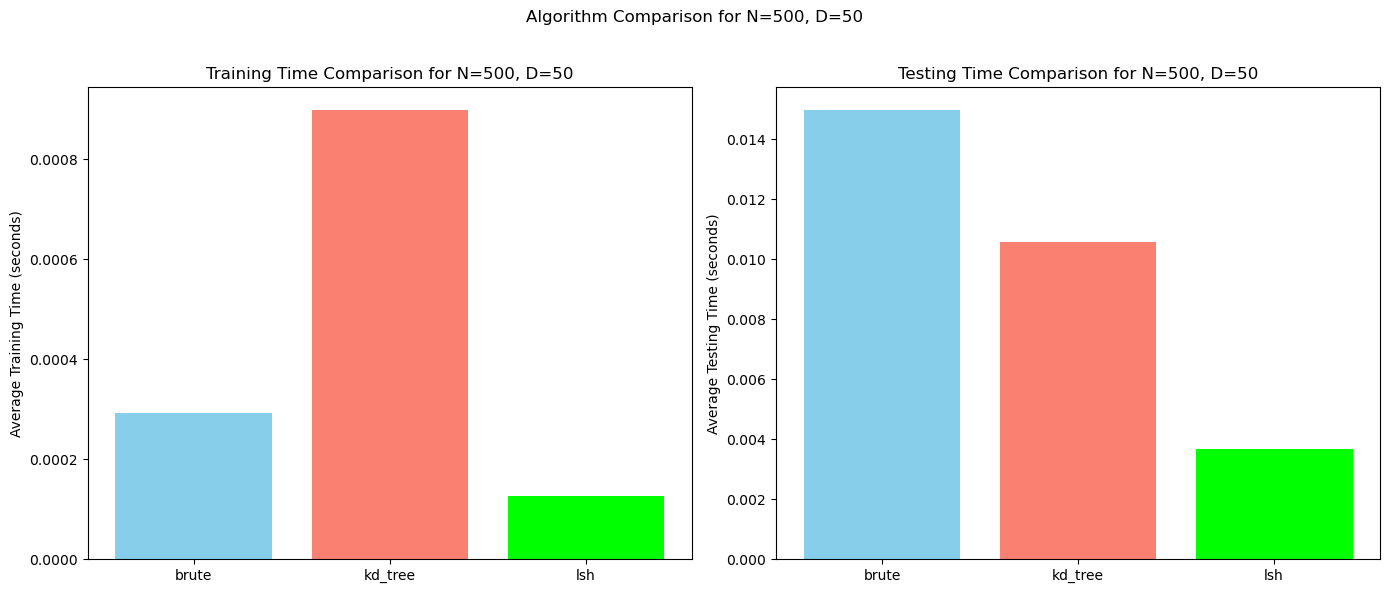

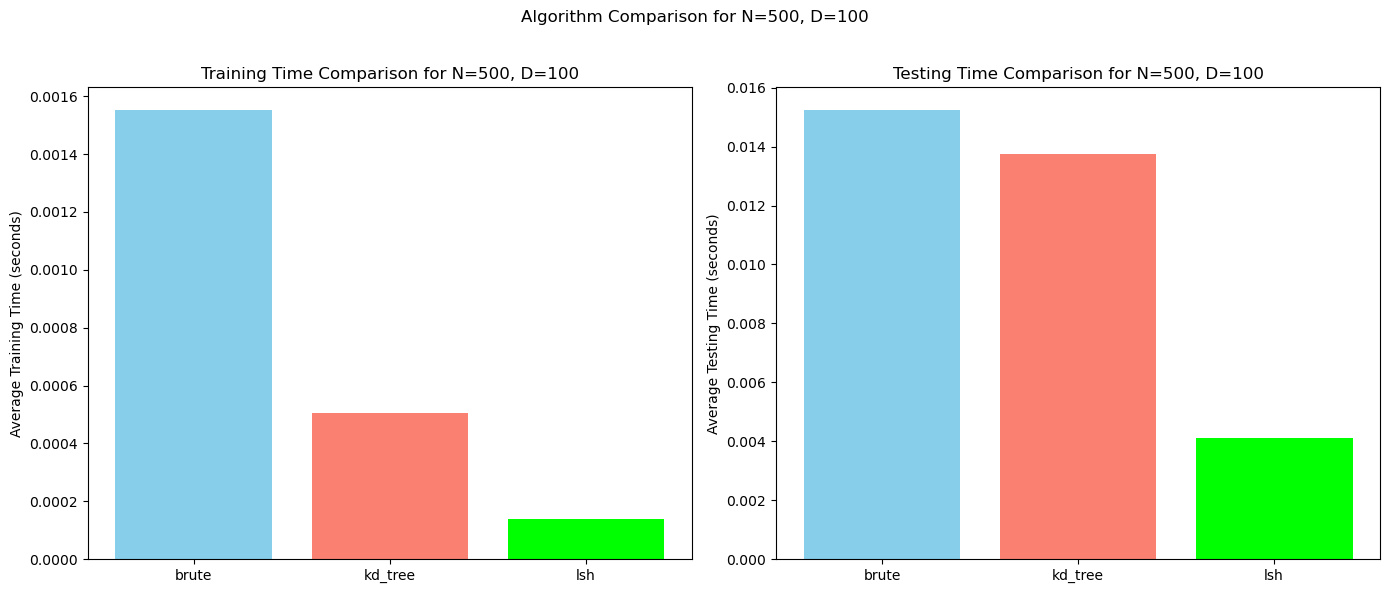

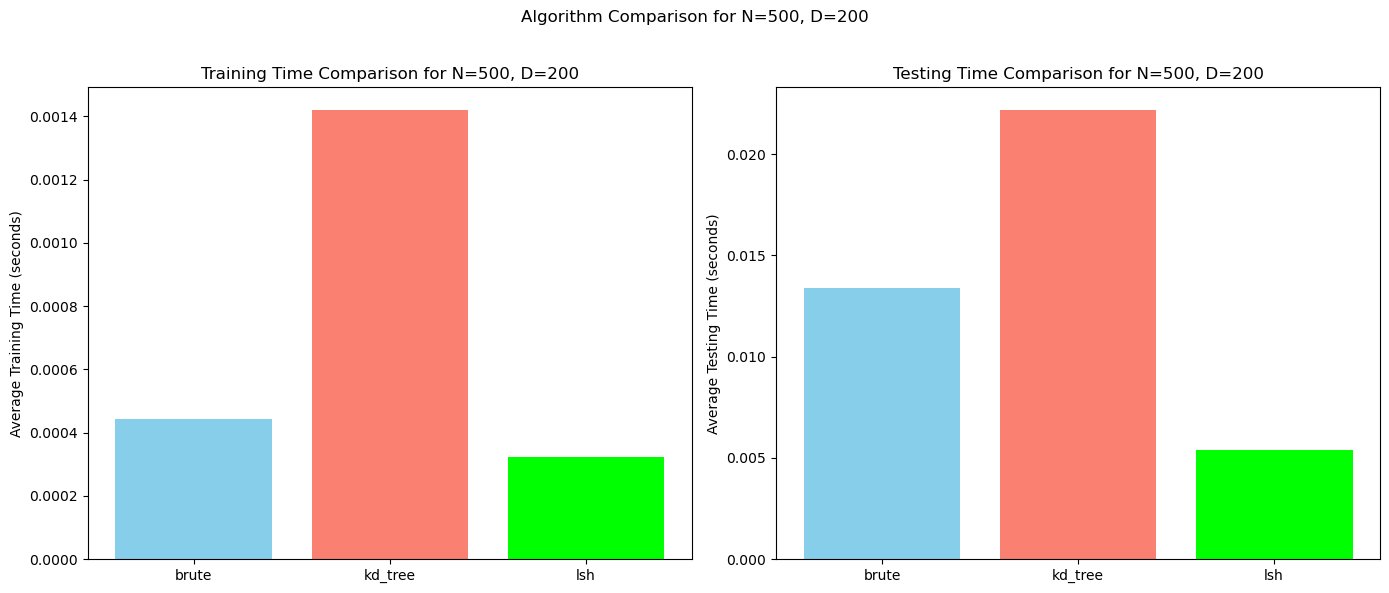

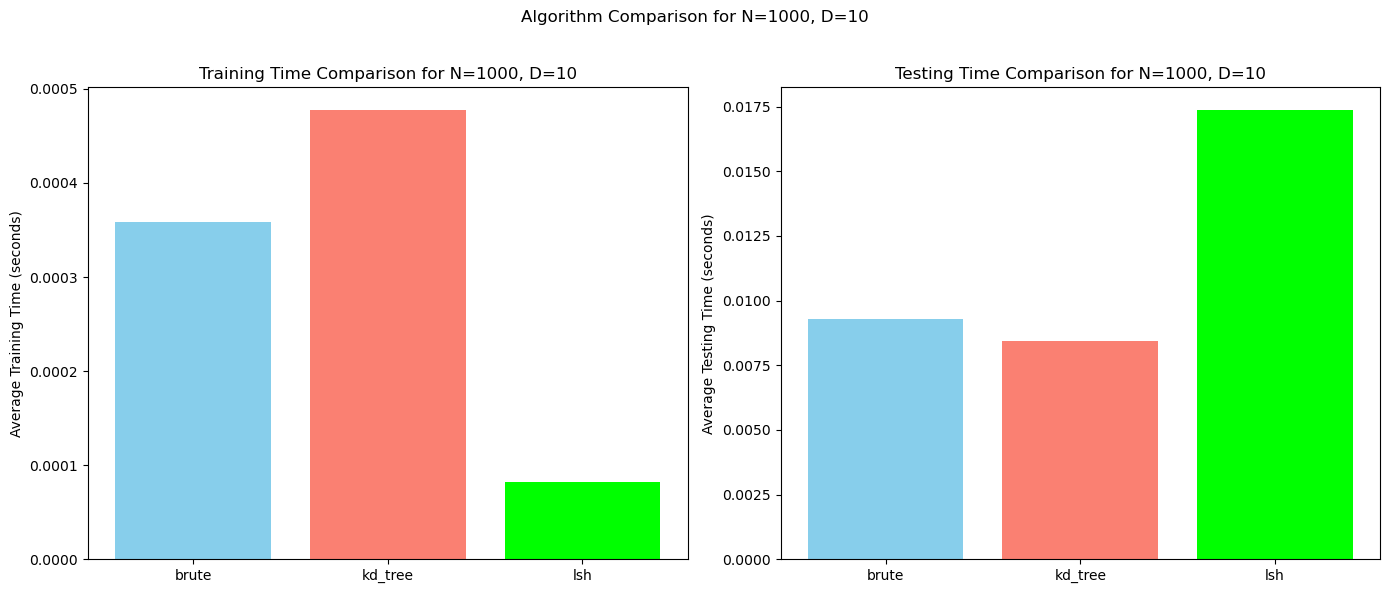

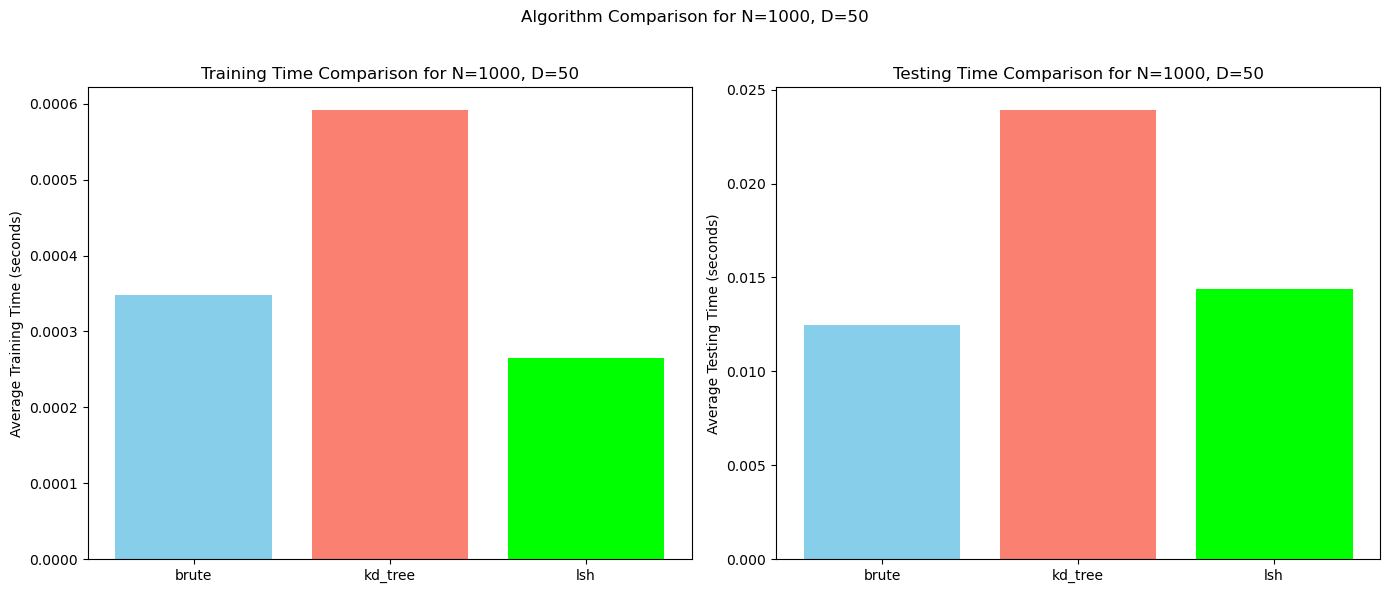

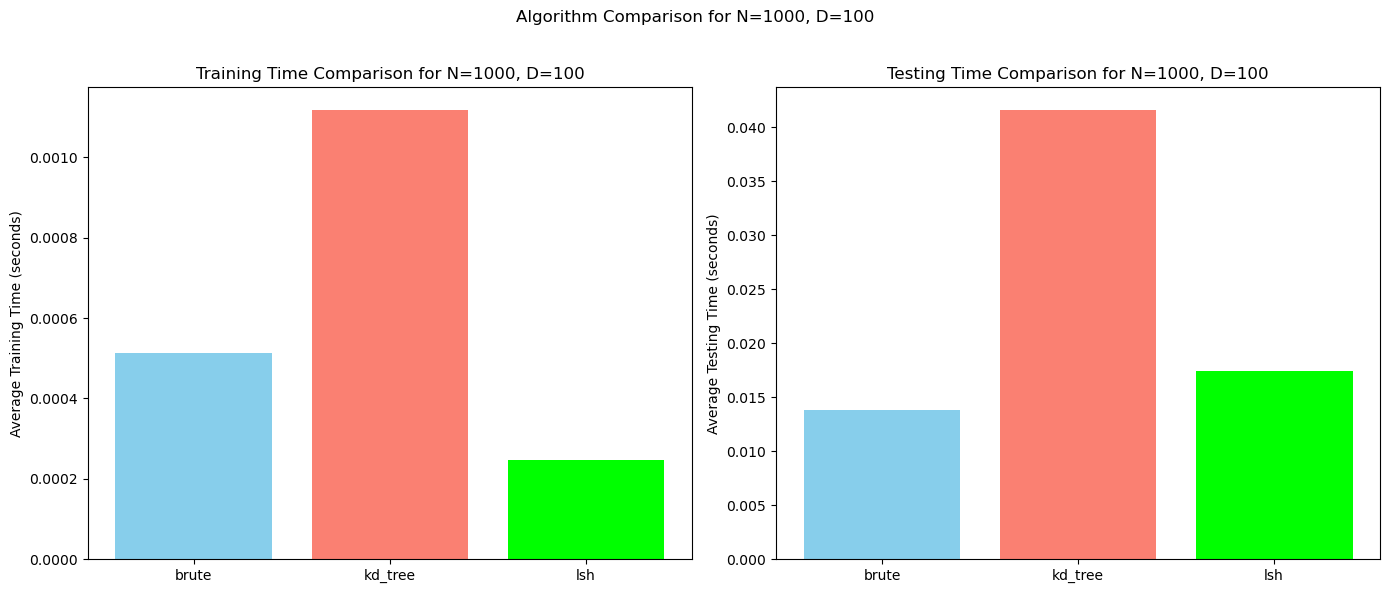

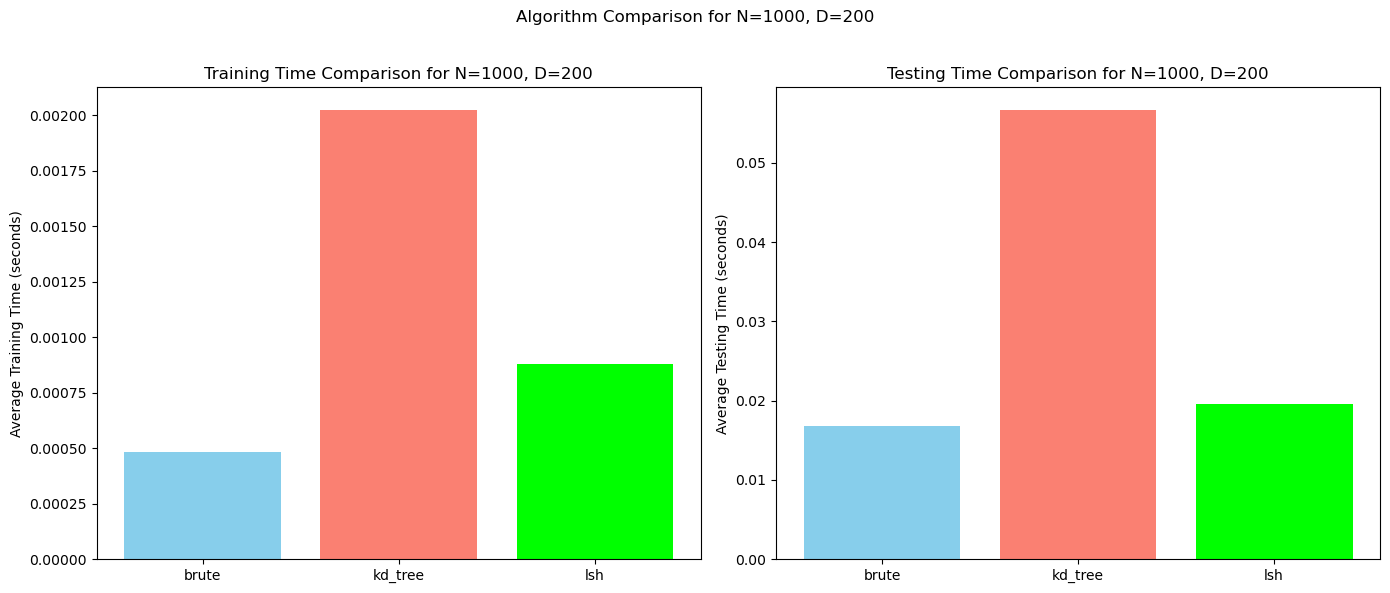

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import timeit
import numpy as np
import tracemalloc

# Predefined LSH Functions
def create_hash_table(X_train, P, seed=35):
    np.random.seed(seed)
    R = np.random.randn(X_train.shape[1] + 1, P)  # +1 for bias term
    X_train_aug = np.hstack([np.ones((X_train.shape[0], 1)), X_train])  # Augment with bias
    H_table = np.sign(X_train_aug @ R)
    return H_table, R, X_train_aug

def predict_lsh(X_test, X_train, y_train, R, H_table, k=3):
    X_test_aug = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
    y_pred = np.zeros(len(X_test), dtype=int)
    for i in range(len(X_test)):
        hash = np.sign(X_test_aug[i] @ R)
        matching_indices = np.where((H_table == hash).all(axis=1))[0]
        if len(matching_indices) == 0:
            y_pred[i] = np.random.choice(y_train)
            continue
        hash_points = X_train[matching_indices]
        labels = y_train[matching_indices]
        distances = np.linalg.norm(hash_points - X_test[i], axis=1)
        closest_indices = np.argsort(distances)[:k]
        k_labels = labels[closest_indices]
        y_pred[i] = np.bincount(k_labels).argmax()
    return y_pred

def measure_memory(func, *args, **kwargs):
    tracemalloc.start()
    func(*args, **kwargs)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return peak / 1024 / 1024  # Convert to MB

# Parameters
N_values = [10, 100, 500, 1000]  # Different sample sizes
D_values = [10, 50, 100, 200]   # Different feature sizes
n_runs = 10  # Number of repetitions for averaging time
algorithms = ['brute', 'kd_tree', 'lsh']  # Include LSH as a third algorithm

# Dictionaries to store times and memory
train_times = {N: {D: {} for D in D_values} for N in N_values}
test_times = {N: {D: {} for D in D_values} for N in N_values}
train_memory = {N: {D: {} for D in D_values} for N in N_values}
test_memory = {N: {D: {} for D in D_values} for N in N_values}

# Experiment
for algo in algorithms:
    for N in N_values:
        for D in D_values:
            # Generate synthetic dataset
            X, y = make_classification(n_samples=N, n_features=D, n_informative=int(D * 0.6),
                                       n_redundant=int(D * 0.2), n_classes=3, random_state=42)

            # Split and scale the dataset
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
            sc = StandardScaler()
            X_train = sc.fit_transform(X_train)
            X_test = sc.transform(X_test)

            if algo == 'lsh':
                P = 10  # Number of random projections
                H_table, R, X_train_aug = create_hash_table(X_train, P)
                
                # Measure training time and memory
                train_time = timeit.timeit(lambda: create_hash_table(X_train, P), number=n_runs)
                train_avg_time = train_time / n_runs
                train_avg_memory = measure_memory(create_hash_table, X_train, P)

                # Measure testing time and memory
                test_time = timeit.timeit(lambda: predict_lsh(X_test, X_train, y_train, R, H_table, k=5), number=n_runs)
                test_avg_time = test_time / n_runs
                test_avg_memory = measure_memory(predict_lsh, X_test, X_train, y_train, R, H_table, k=5)

            else:
                classifier = KNeighborsClassifier(n_neighbors=5, algorithm=algo)
                
                # Measure training time and memory
                train_time = timeit.timeit(lambda: classifier.fit(X_train, y_train), number=n_runs)
                train_avg_time = train_time / n_runs
                train_avg_memory = measure_memory(classifier.fit, X_train, y_train)

                # Measure testing time and memory
                test_time = timeit.timeit(lambda: classifier.predict(X_test), number=n_runs)
                test_avg_time = test_time / n_runs
                test_avg_memory = measure_memory(classifier.predict, X_test)

            # Store times and memory usage
            train_times[N][D][algo] = train_avg_time
            test_times[N][D][algo] = test_avg_time
            train_memory[N][D][algo] = train_avg_memory
            test_memory[N][D][algo] = test_avg_memory

# Plotting bar graphs comparing algorithms
for N in N_values:
    for D in D_values:
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        # Training time comparison
        algos = list(train_times[N][D].keys())
        train_times_values = [train_times[N][D][algo] for algo in algos]
        ax[0].bar(algos, train_times_values, color=['skyblue', 'salmon', 'lime'])
        ax[0].set_ylabel("Average Training Time (seconds)")
        ax[0].set_title(f"Training Time Comparison for N={N}, D={D}")

        # Testing time comparison
        test_times_values = [test_times[N][D][algo] for algo in algos]
        ax[1].bar(algos, test_times_values, color=['skyblue', 'salmon', 'lime'])
        ax[1].set_ylabel("Average Testing Time (seconds)")
        ax[1].set_title(f"Testing Time Comparison for N={N}, D={D}")

        plt.suptitle(f"Algorithm Comparison for N={N}, D={D}")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


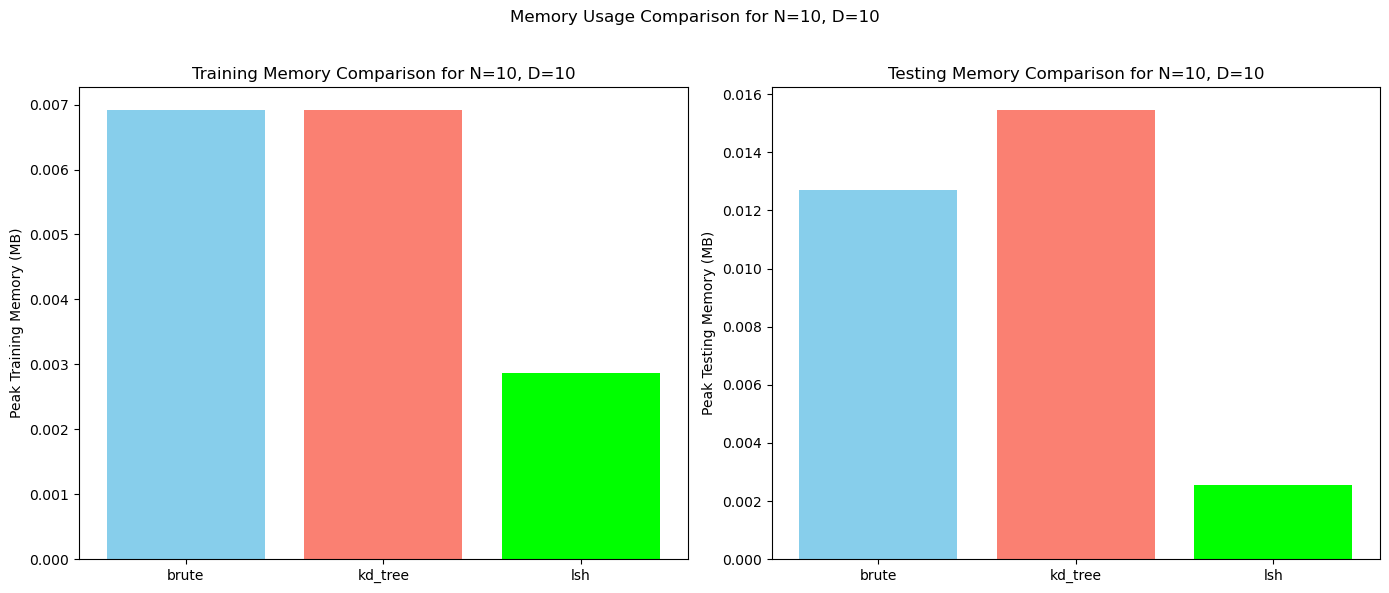

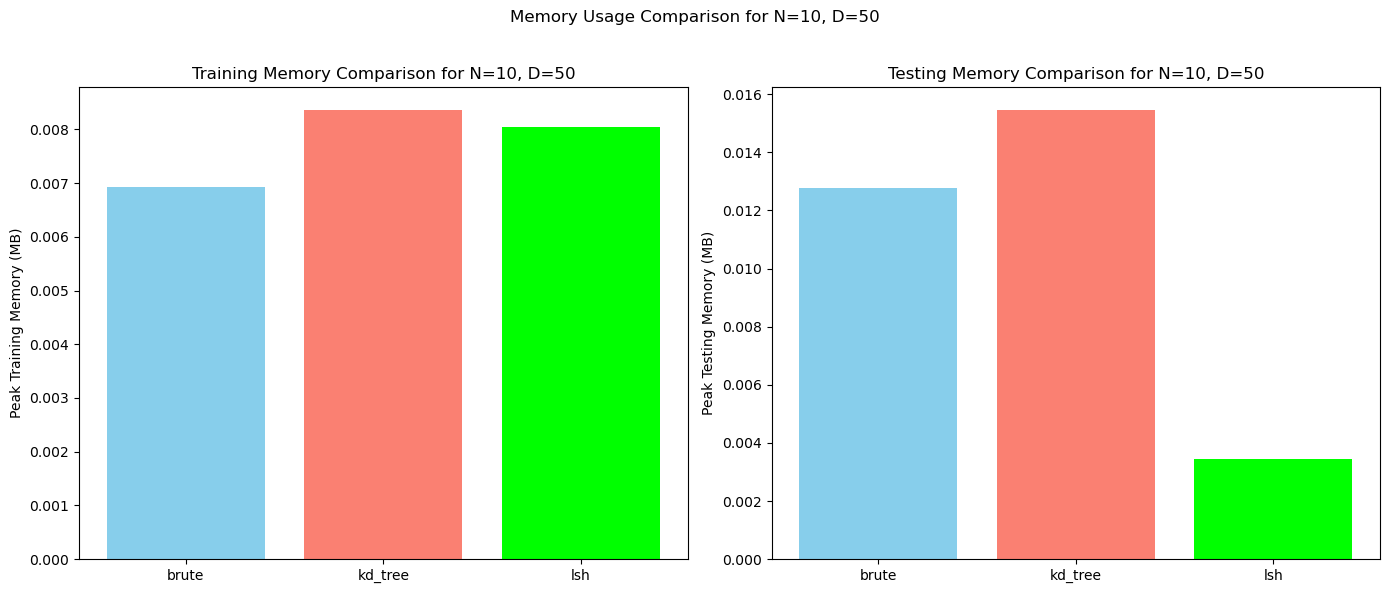

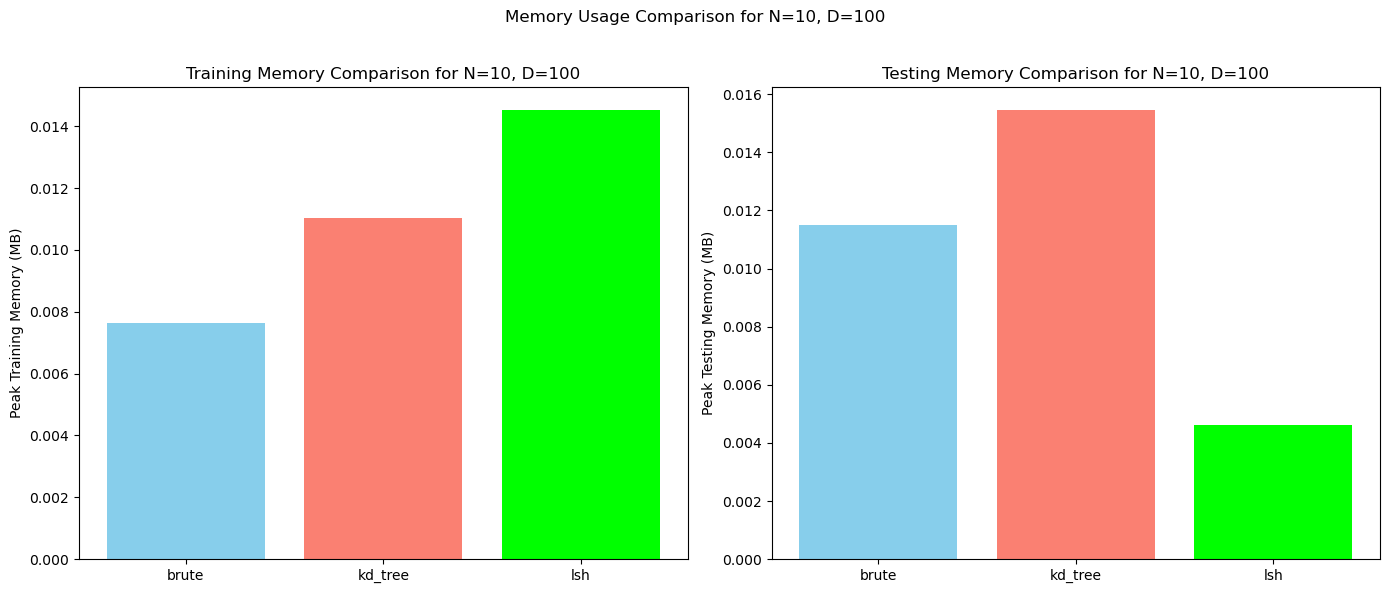

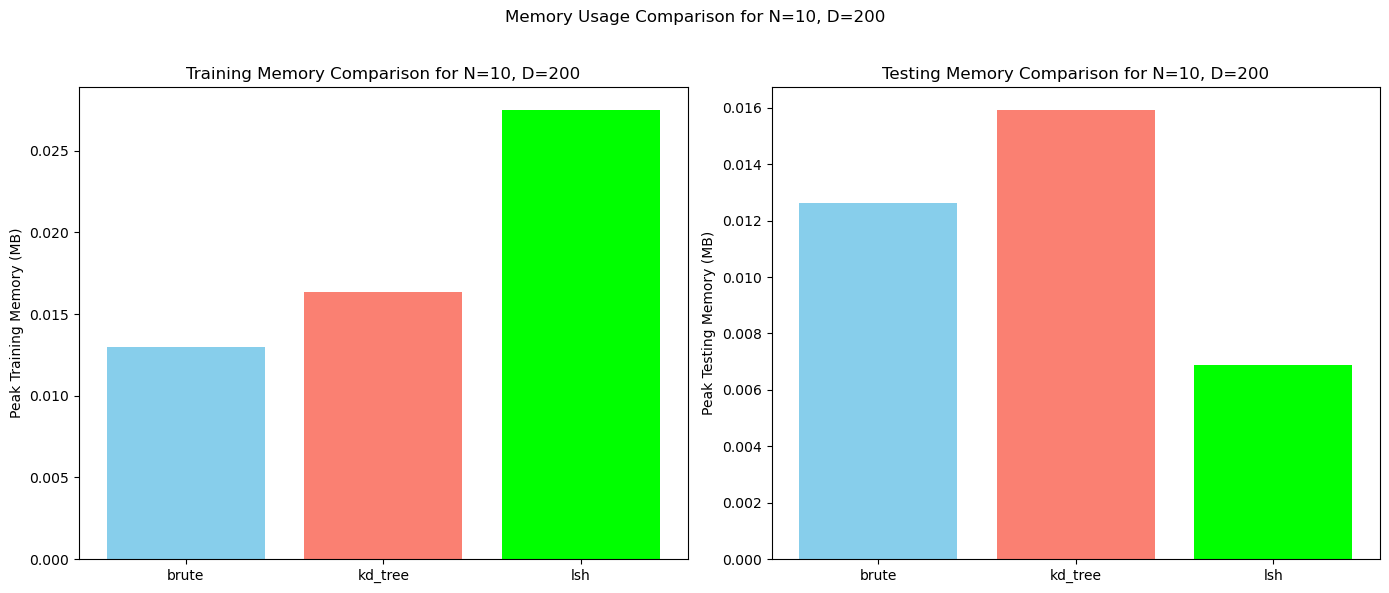

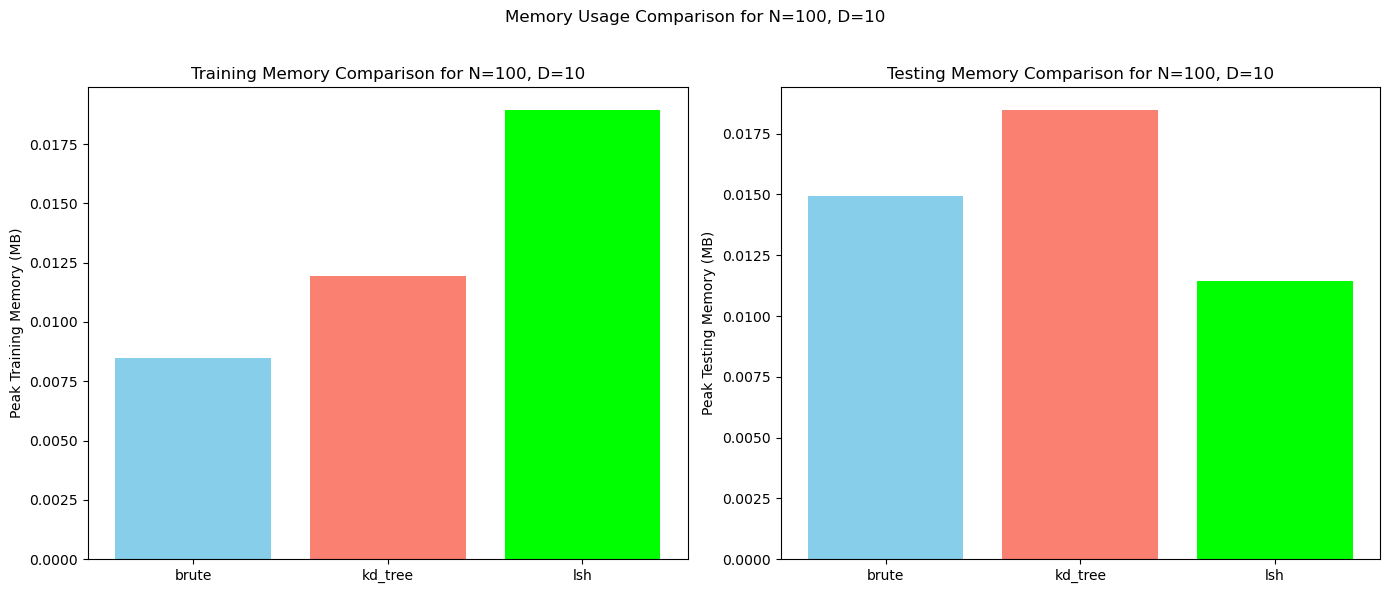

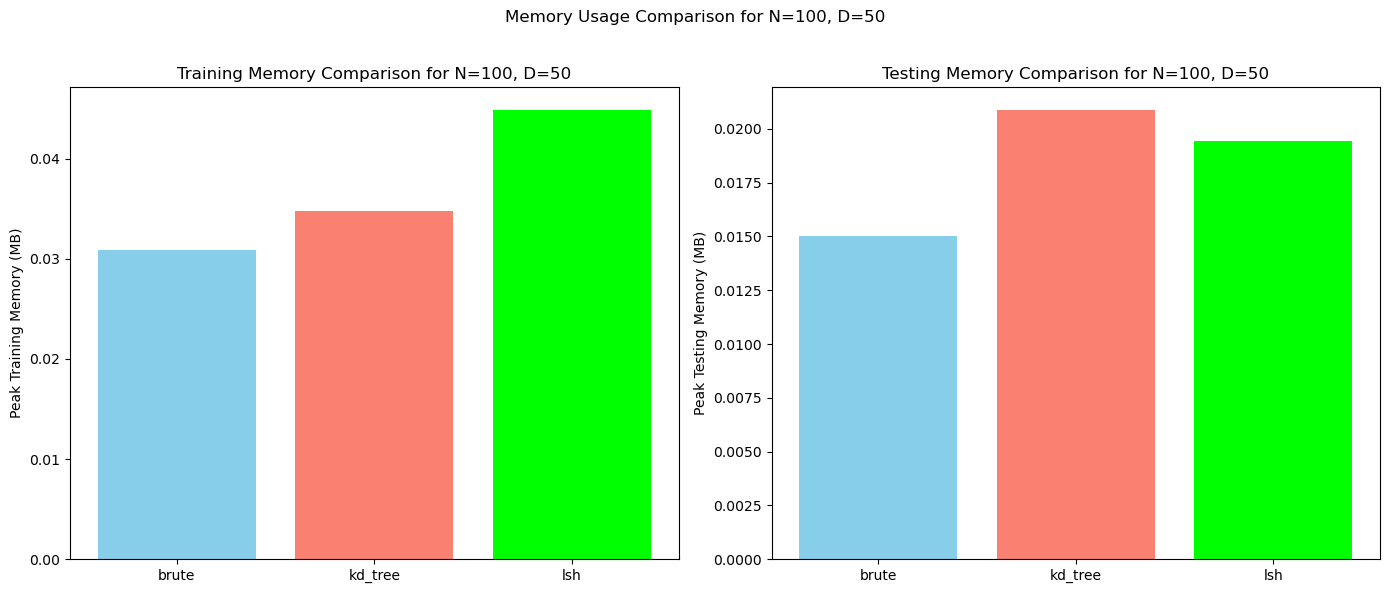

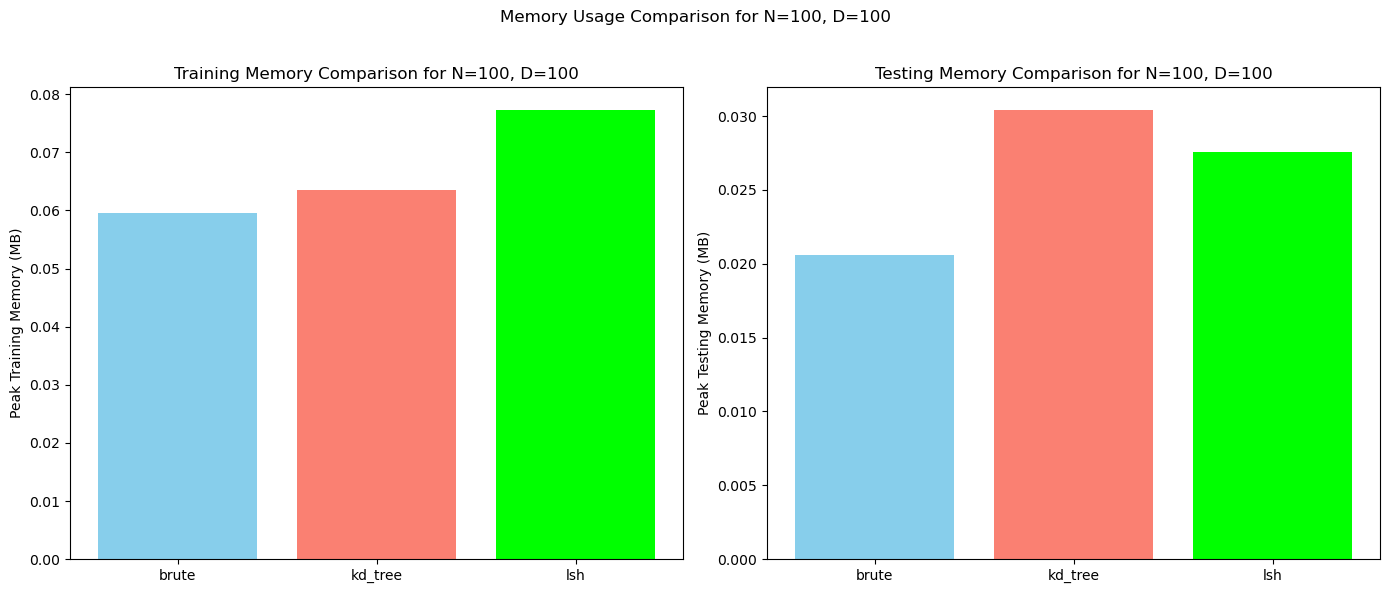

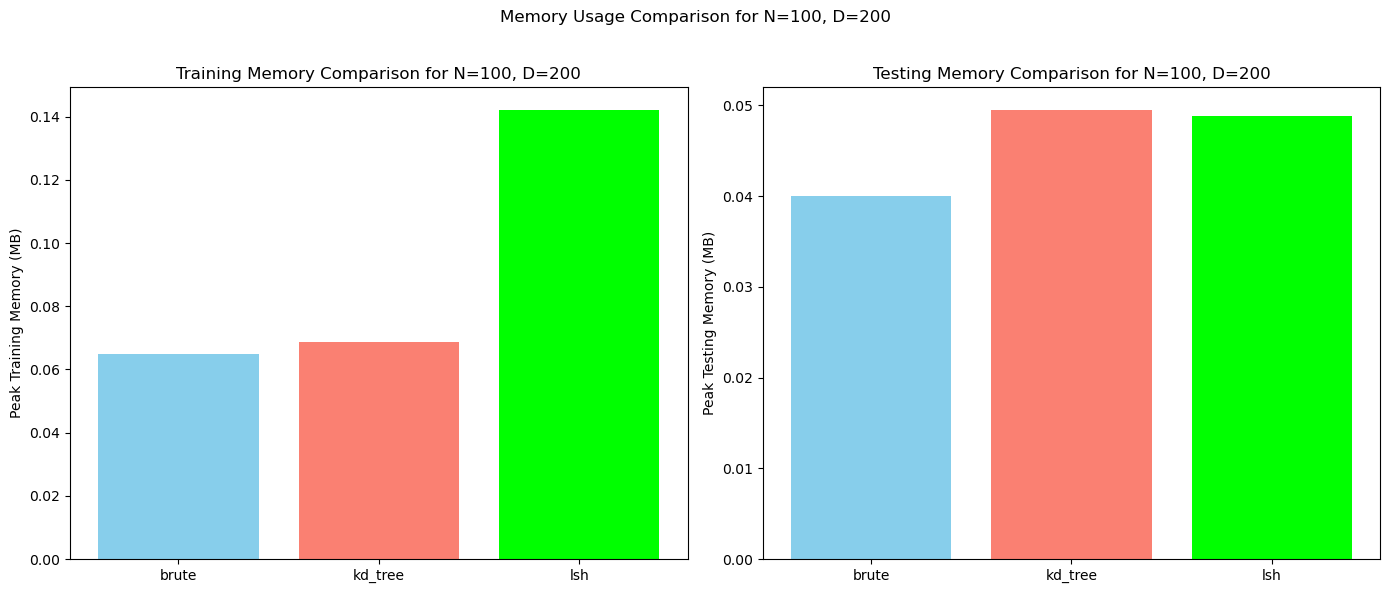

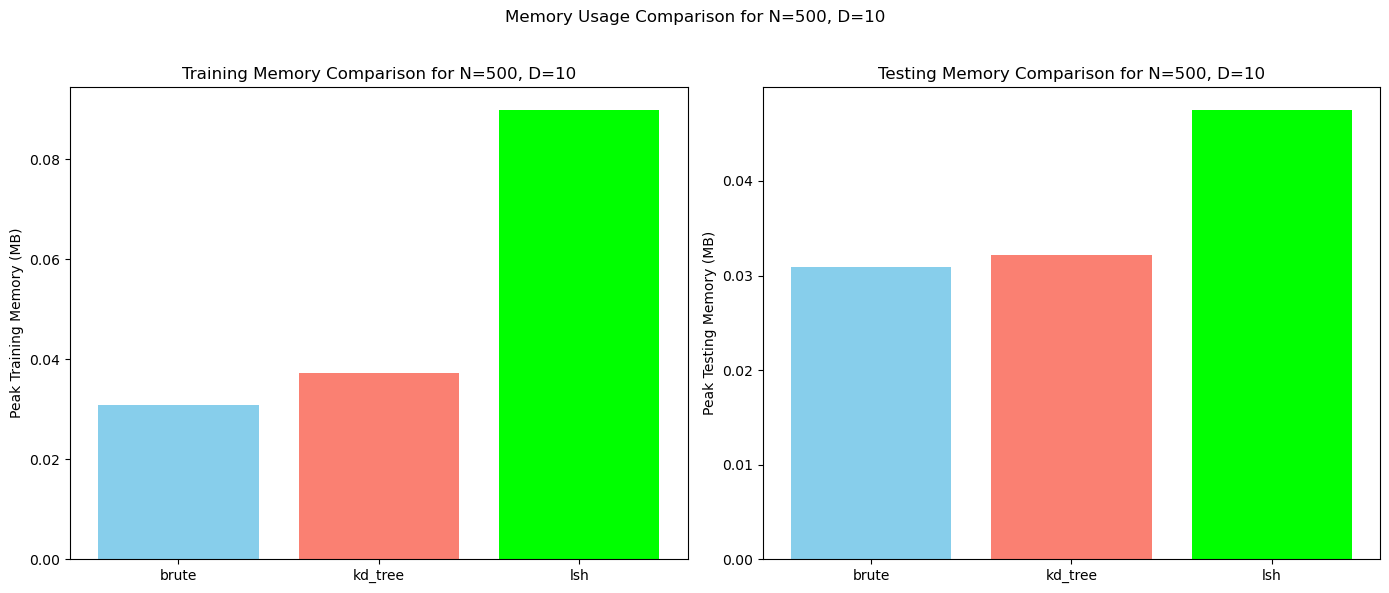

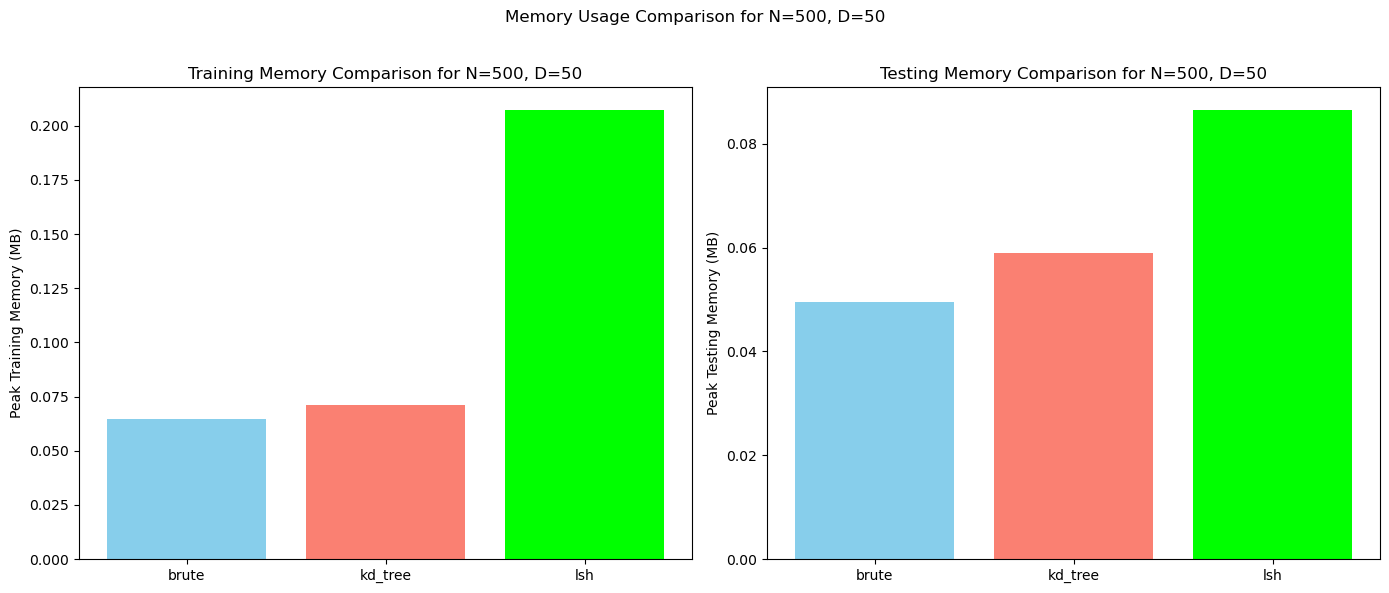

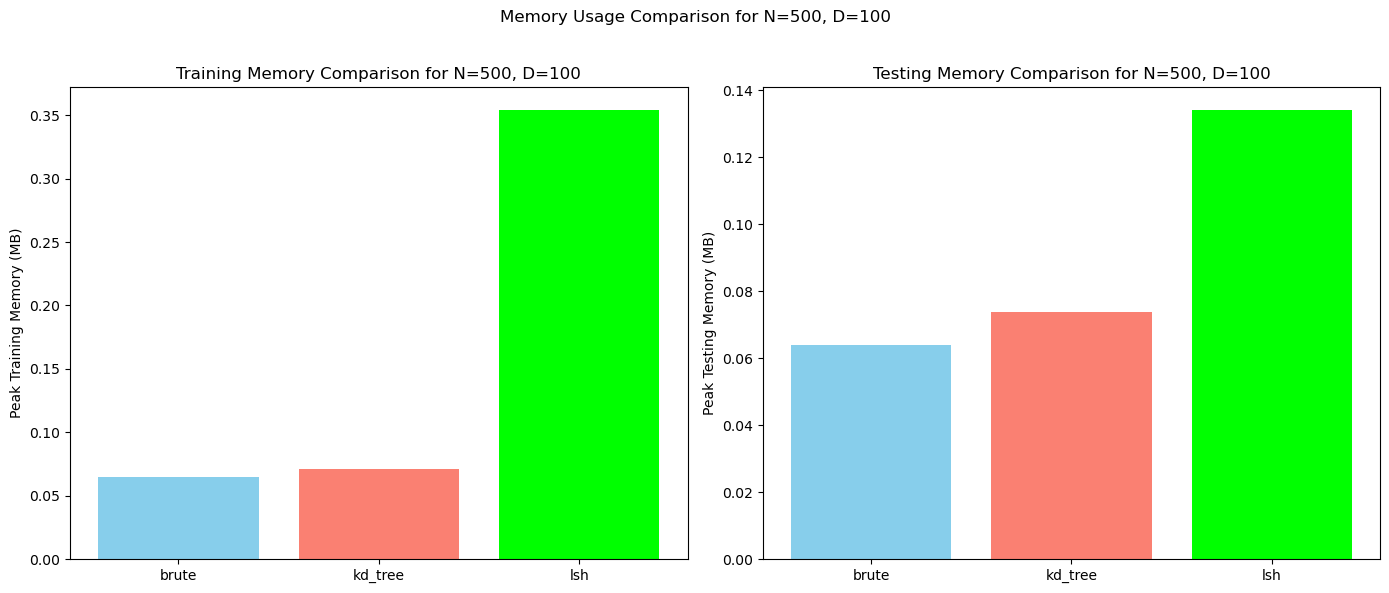

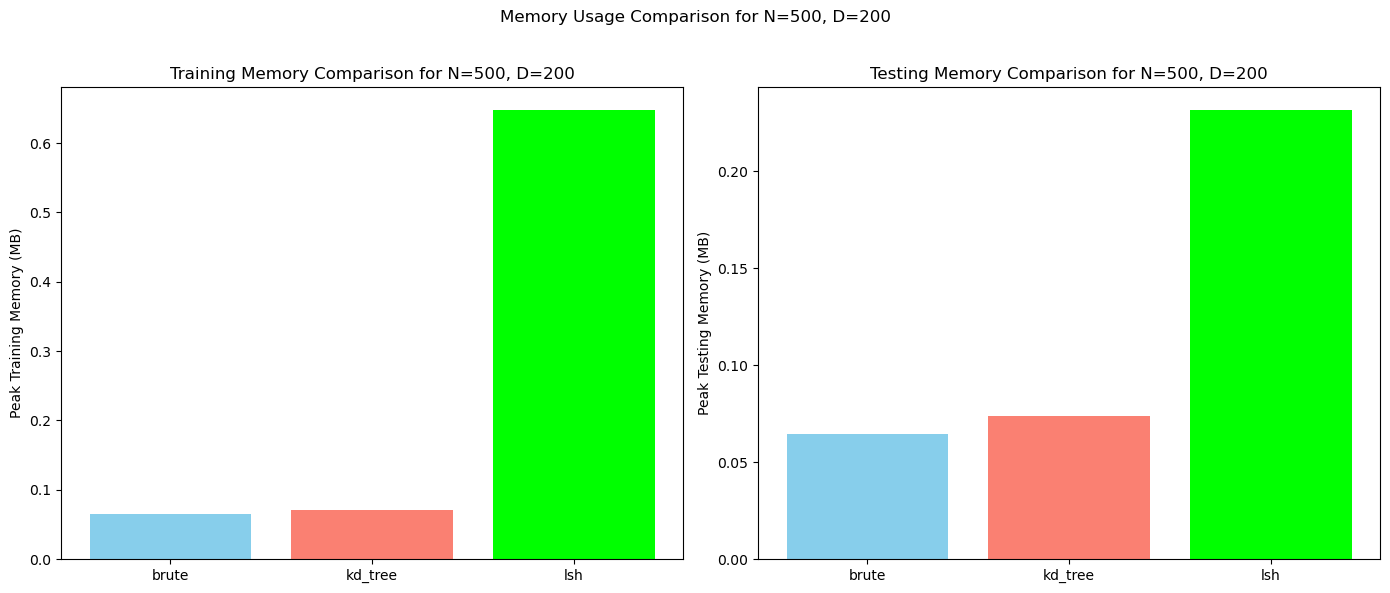

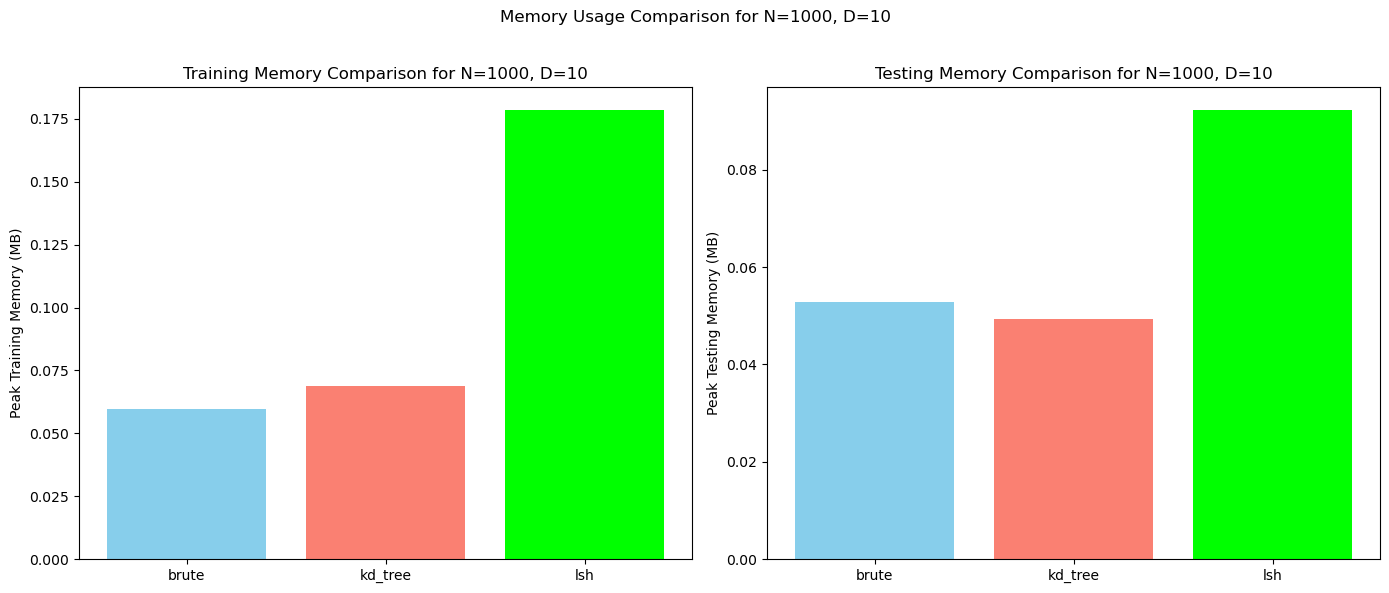

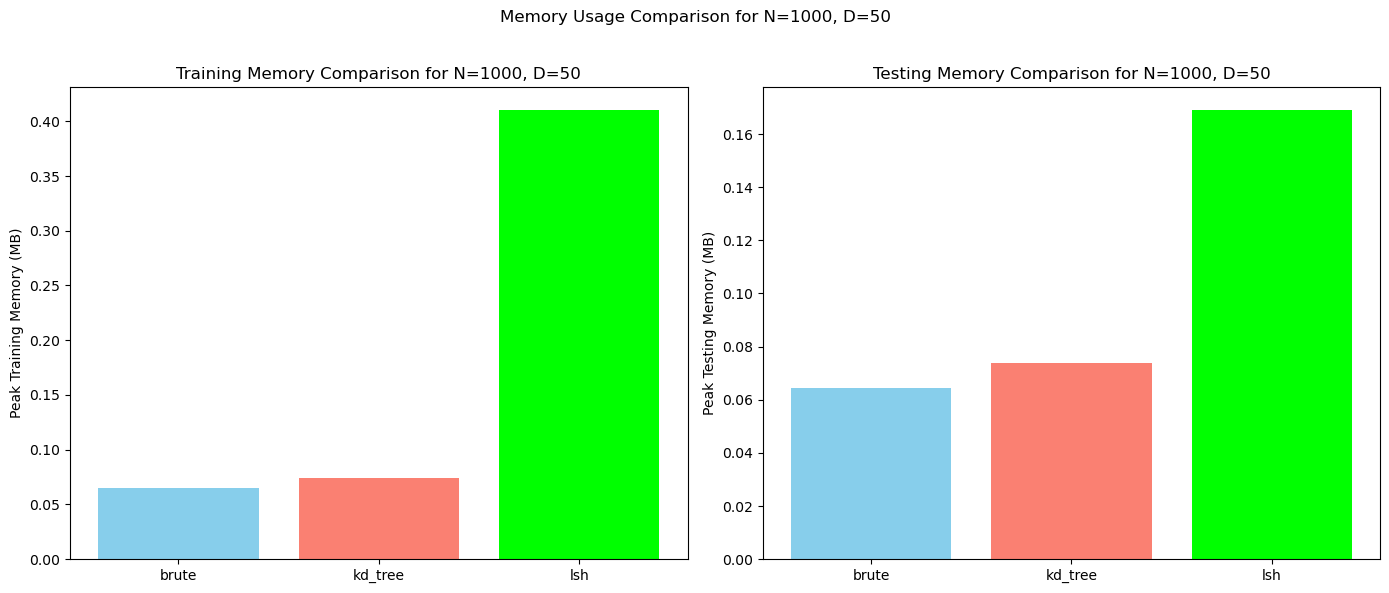

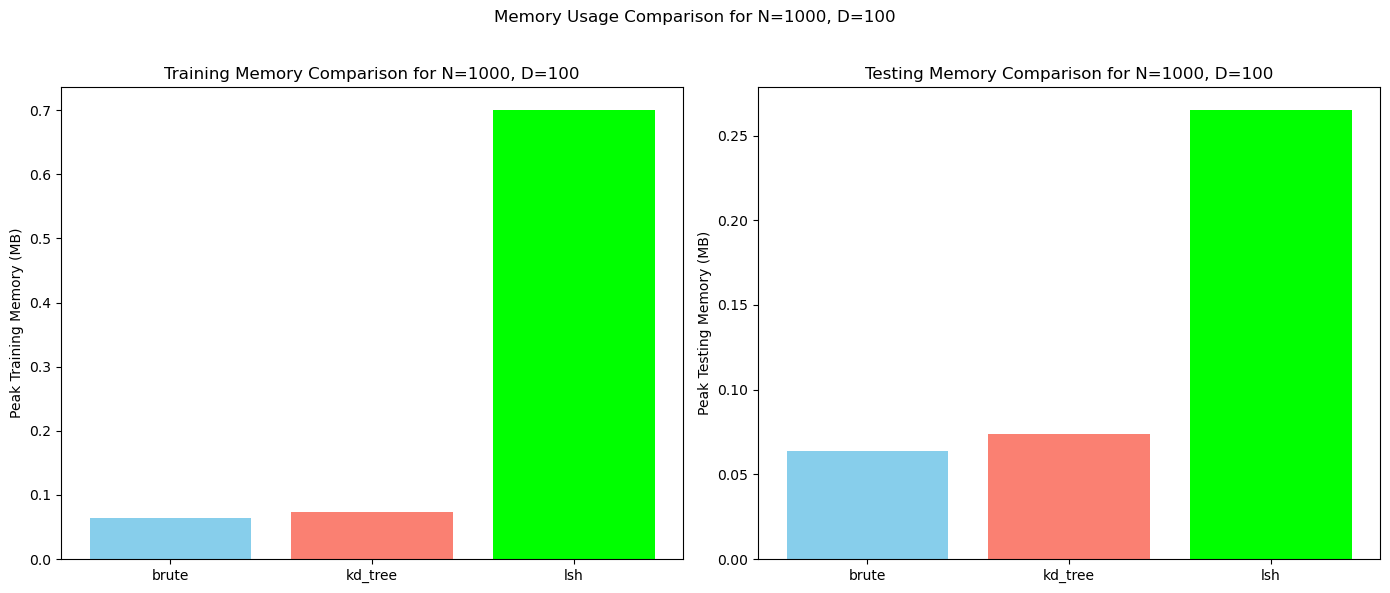

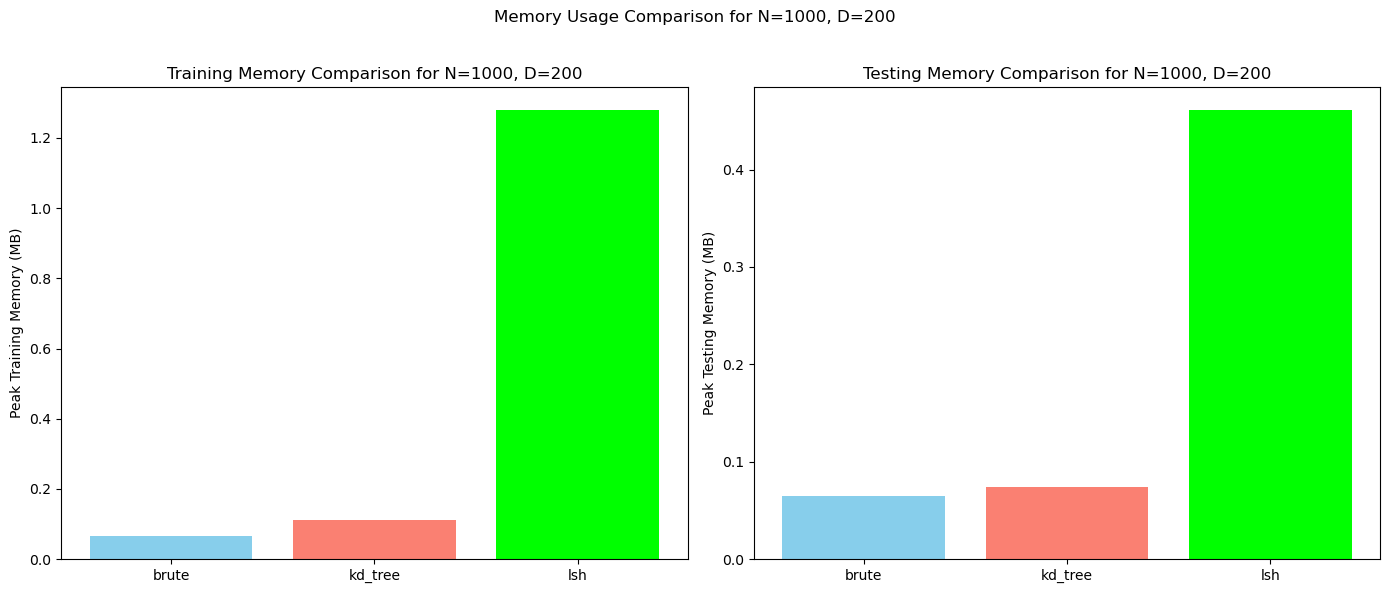

In [3]:
# Plotting Memory Comparison
for N in N_values:
    for D in D_values:
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        # Training memory comparison
        algos = list(train_memory[N][D].keys())
        train_memory_values = [train_memory[N][D][algo] for algo in algos]
        ax[0].bar(algos, train_memory_values, color=['skyblue', 'salmon', 'lime'])
        ax[0].set_ylabel("Peak Training Memory (MB)")
        ax[0].set_title(f"Training Memory Comparison for N={N}, D={D}")

        # Testing memory comparison
        test_memory_values = [test_memory[N][D][algo] for algo in algos]
        ax[1].bar(algos, test_memory_values, color=['skyblue', 'salmon', 'lime'])
        ax[1].set_ylabel("Peak Testing Memory (MB)")
        ax[1].set_title(f"Testing Memory Comparison for N={N}, D={D}")

        plt.suptitle(f"Memory Usage Comparison for N={N}, D={D}")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
